# Airbnb NYC Data Pre-processing & ETL

This notebook implements the end-to-end data pipeline to create the final modeling dataset from raw InsideAirbnb snapshots.

**Objective:** Load all monthly listings snapshots and the full reviews history, clean features, engineer the `estimated_occupancy_rate` sample weight, and produce a single, model-ready `listing-month` panel.

### 0. Setup & Data Loading

In [14]:
import pandas as pd
import numpy as np
import os
import glob

# --- Configuration ---
# Parent directory containing the 'listings-YY-MM.csv' files and '{CITY}-reviews-detailed...csv'
CITY = "toronto"
INPUT_DATA_DIR = os.path.expanduser(f"~/Downloads/insideairbnb/{CITY}") 
OUTPUT_DATA_DIR = os.path.expanduser(f"../data/{CITY}")
OUTPUT_FILENAME = f"{CITY}_dataset_oct_20.parquet"

# Configure pandas display
pd.options.display.max_columns = 100

# --- Load All Monthly Listings Snapshots ---
listings_files = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, 'listings-*.csv')))
if not listings_files:
    raise FileNotFoundError(f"No 'listings-*.csv' files found in {INPUT_DATA_DIR}")

print(f"Found {len(listings_files)} monthly listings files. Loading and concatenating...")

dfs = []
for file in listings_files:
    # low_memory=False handles mixed data types in raw CSVs
    df = pd.read_csv(file, low_memory=False) 
    dfs.append(df)

raw_listings_df = pd.concat(dfs, ignore_index=True)
print(f"Successfully loaded {len(raw_listings_df):,} total listing records.")

# --- Load Full Reviews History ---
reviews_path = os.path.join(INPUT_DATA_DIR, f'{CITY}-reviews-detailed-insideairbnb.csv')
print(f"Loading reviews from: {os.path.basename(reviews_path)}...")
try:
    raw_reviews_df = pd.read_csv(reviews_path)
    print(f"Successfully loaded {len(raw_reviews_df):,} reviews.")
except FileNotFoundError:
    raise FileNotFoundError(f"Could not find reviews file at: {reviews_path}")

# Display samples
print("\nListings Sample:")
display(raw_listings_df.head(2))
print("\nReviews Sample:")
display(raw_reviews_df.head(2))

# Display column info
print("\nListings DataFrame Info:")
print(raw_listings_df.info())
print("\nReviews DataFrame Info:")
print(raw_reviews_df.info())

Found 12 monthly listings files. Loading and concatenating...
Successfully loaded 259,178 total listing records.
Loading reviews from: toronto-reviews-detailed-insideairbnb.csv...
Successfully loaded 634,104 reviews.

Listings Sample:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d
0,1419,https://www.airbnb.com/rooms/1419,20241005023627,2024-10-05,previous scrape,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Vancouver, Canada","I live in Vancouver, Canada with my husband an...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/7aeea...,https://a0.muscache.com/im/pictures/user/7aeea...,Commercial Drive,1.0,1.0,"['email', 'phone']",t,t,Neighborhood highlights,Little Portugal,NaN,43.6459,-79.42423,Entire home,Entire home/apt,10,NaN,3 baths,5.0,NaN,"[""Smoke alarm"", ""Wifi"", ""Kitchen"", ""Essentials...",NaN,28,730,28.0,28.0,730.0,730.0,28.0,730.0,NaN,t,0,0,0,0,2024-10-05,6,0,0,2015-07-19,2017-08-07,5.00,5.00,5.00,5.00,5.0,5.00,5.00,NaN,f,1,1,0,0,0.05,NaN,NaN,NaN,NaN
1,8077,https://www.airbnb.com/rooms/8077,20241005023627,2024-10-05,previous scrape,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/9a077...,https://a0.muscache.com/im/pictures/user/9a077...,Harbourfront,2.0,3.0,"['email', 'phone']",t,f,NaN,Waterfront Communities-The Island,NaN,43.6408,-79.37673,Private room in rental unit,Private room,2,NaN,1.5 baths,NaN,NaN,"[""Free parking on premises"", ""Smoke alarm"", ""W...",NaN,180,365,180.0,180.0,365.0,365.0,180.0,365.0,NaN,NaN,0,0,0,0,2024-10-05,169,0,0,2009-08-20,2013-08-27,4.84,4.81,4.89,4.87,4.9,4.92,4.83,NaN,f,2,1,1,0,0.92,NaN,NaN,NaN,NaN



Reviews Sample:


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1419,38924112,2015-07-19,11308465,Marcela,Having the opportunity of arriving to Alexandr...
1,1419,44791978,2015-08-29,9580285,Marco,We have no enough words to describe how beauty...



Listings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259178 entries, 0 to 259177
Data columns (total 79 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            259178 non-null  int64  
 1   listing_url                                   259178 non-null  object 
 2   scrape_id                                     259178 non-null  int64  
 3   last_scraped                                  259178 non-null  object 
 4   source                                        259178 non-null  object 
 5   name                                          259178 non-null  object 
 6   description                                   253815 non-null  object 
 7   neighborhood_overview                         119863 non-null  object 
 8   picture_url                                   259178 non-null  object 
 9   host_id               

### 1. Remove unnecessary columns

In [15]:
cols_to_keep = [
    'id',
    'host_id',
    'name',
    'description',
    'host_is_superhost',
    'neighbourhood_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'amenities',
    'minimum_nights',
    'review_scores_rating',  #float
    'review_scores_accuracy',  #float
    'review_scores_cleanliness',  #float
    'review_scores_checkin',  #float
    'review_scores_communication',  #float
    'review_scores_location',  #float
    'review_scores_value',  #float
    'last_scraped',
    'price'
    ]

listings_df = raw_listings_df[cols_to_keep].copy()
print(f"\nReduced listings DataFrame to {len(listings_df.columns)} columns.")
print(listings_df.info())


Reduced listings DataFrame to 25 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259178 entries, 0 to 259177
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           259178 non-null  int64  
 1   host_id                      259178 non-null  int64  
 2   name                         259178 non-null  object 
 3   description                  253815 non-null  object 
 4   host_is_superhost            249001 non-null  object 
 5   neighbourhood_cleansed       259178 non-null  object 
 6   latitude                     259178 non-null  float64
 7   longitude                    259178 non-null  float64
 8   property_type                259178 non-null  object 
 9   room_type                    259178 non-null  object 
 10  accommodates                 259178 non-null  int64  
 11  bathrooms                    190841 non-null  float64
 12  bedrooms       

### 2. Convert the scrape-date to month (1-12), convert `host_is_superhost` col to numeric 0/1

In [16]:
# Convert last_scraped to datetime
raw_listings_df['last_scraped'] = pd.to_datetime(raw_listings_df['last_scraped'], errors='coerce')

# Convert last_scraped to month only (no year)
listings_df['month'] = raw_listings_df['last_scraped'].dt.month

# Drop the last_scraped column as it's no longer needed
listings_df = listings_df.drop(columns=['last_scraped'])

### 3. Clean price column, drop outliers, add price-per-person and log1p of both

In [17]:
# Convert prices to float
listings_df['price'] = listings_df['price'].replace(r'[\$,]', '', regex=True).astype(float)

# Drop NaN's from price column and make it float
listings_df = listings_df.dropna(subset=['price'])

# Add price_per_person column
listings_df['price_per_person'] = listings_df['price'] / listings_df['accommodates']

# Drop the bottom 5% and top 5% of price_per_person to remove outliers
lower_bound = listings_df['price_per_person'].quantile(0.05)
upper_bound = listings_df['price_per_person'].quantile(0.95)
listings_df = listings_df[(listings_df['price_per_person'] >= lower_bound) & (listings_df['price_per_person'] <= upper_bound)]

# Add log1p transformed columns
listings_df['log_price'] = np.log1p(listings_df['price'])
listings_df['log_price_per_person'] = np.log1p(listings_df['price_per_person'])

# Print info and a sample
print("\nUpdated Listings DataFrame Info:")
print(listings_df.info())
print("\nListings DataFrame Sample with New Columns:")
display(listings_df.head(5))


Updated Listings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 172576 entries, 2 to 259177
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           172576 non-null  int64  
 1   host_id                      172576 non-null  int64  
 2   name                         172576 non-null  object 
 3   description                  170026 non-null  object 
 4   host_is_superhost            165106 non-null  object 
 5   neighbourhood_cleansed       172576 non-null  object 
 6   latitude                     172576 non-null  float64
 7   longitude                    172576 non-null  float64
 8   property_type                172576 non-null  object 
 9   room_type                    172576 non-null  object 
 10  accommodates                 172576 non-null  int64  
 11  bathrooms                    172468 non-null  float64
 12  bedrooms                     

,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person
2,26654,113345,"World Class @ CN Tower, convention centre, The...","CN Tower, TIFF Bell Lightbox, Metro Convention...",t,Waterfront Communities-The Island,43.64608,-79.39032,Entire condo,Entire home/apt,4,1.0,1.0,2.0,"[""Iron"", ""Building staff"", ""City skyline view""...",28,4.79,4.79,4.79,4.64,4.76,4.86,4.67,155.0,10,38.750000,5.049856,3.682610
6,40701,175687,Bright Beaches loft close to Queen and the lake,Highly walkable neighborhood. Close to the lak...,f,The Beaches,43.67239,-79.28858,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,"[""Window AC unit"", ""Stove"", ""Iron"", ""Coffee ma...",28,4.75,4.88,4.38,4.88,4.63,4.88,4.50,85.0,10,42.500000,4.454347,3.772761
7,44452,195095,Yonge & Bloor Studio Skyline,NaN,t,Rosedale-Moore Park,43.67193,-79.38590,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,"[""Iron"", ""Hot water"", ""Carbon monoxide alarm"",...",28,4.18,4.51,4.03,4.79,4.84,4.95,4.23,126.0,10,63.000000,4.844187,4.158883
8,45399,195095,Fountain View Studio - Eaton center,"Open Space studio style, Big windows, calm & r...",t,Bay Street Corridor,43.66123,-79.38336,Entire condo,Entire home/apt,3,1.0,0.0,1.0,"[""Iron"", ""Hot water"", ""Coffee maker: drip coff...",28,4.17,4.49,3.97,4.63,4.69,4.92,4.21,146.0,10,48.666667,4.990433,3.905334
9,45893,195095,Yonge & Bloor Lakeview Master BR,NaN,t,Rosedale-Moore Park,43.67180,-79.38488,Private room in rental unit,Private room,1,1.0,1.0,1.0,"[""Iron"", ""Coffee maker"", ""Carbon monoxide alar...",28,4.40,4.29,4.00,4.52,4.81,4.86,4.24,90.0,10,90.000000,4.510860,4.510860


### 4. Keep only listings with at least one review, drop rows with NaN's, keep only listings that appear in at least 5 months

In [18]:
# Compare IDs between listings_df and raw_reviews_df
listings_ids = set(listings_df['id'].unique())
reviews_ids = set(raw_reviews_df['listing_id'].unique())

common_ids = listings_ids & reviews_ids
only_in_listings = listings_ids - reviews_ids
only_in_reviews = reviews_ids - listings_ids

print(f"Total unique IDs in listings: {len(listings_ids)}")
print(f"Total unique IDs in reviews: {len(reviews_ids)}")
print(f"Common IDs: {len(common_ids)}")
print(f"IDs only in listings: {len(only_in_listings)}")
print(f"IDs only in reviews: {len(only_in_reviews)}")

# Optionally, display some samples
print("\nSample common IDs:", list(common_ids)[:5])
print("Sample only in listings:", list(only_in_listings)[:5])
print("Sample only in reviews:", list(only_in_reviews)[:5])

# Keep only common IDs in listings and reviews
common_listings_df = listings_df[listings_df['id'].isin(common_ids)]
common_reviews_df = raw_reviews_df[raw_reviews_df['listing_id'].isin(common_ids)]

# Drop all listings with NaN's
common_listings_df = common_listings_df.dropna()

# Keep only listings that appear at least 8 times
common_listings_df = common_listings_df[common_listings_df.groupby('id')['id'].transform('size') >= 8]

# Display info after filtering
print("\nFiltered Listings DataFrame Info:")
print(common_listings_df.info())
print("\nFiltered Reviews DataFrame Info:")
print(common_reviews_df.info())

Total unique IDs in listings: 25737
Total unique IDs in reviews: 16546
Common IDs: 13639
IDs only in listings: 12098
IDs only in reviews: 2907

Sample common IDs: [np.int64(35880960), np.int64(1081313620383858689), np.int64(1136166639130869762), np.int64(1239457201874862082), np.int64(1312646562476523531)]
Sample only in listings: [np.int64(986302774835249152), np.int64(594055665721704452), np.int64(1343715665444208646), np.int64(1022457932458819592), np.int64(1103777582724939786)]
Sample only in reviews: [np.int64(38731776), np.int64(23248896), np.int64(28606469), np.int64(36610053), np.int64(27549705)]

Filtered Listings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 86392 entries, 2 to 255837
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           86392 non-null  int64  
 1   host_id                      86392 non-null  int64  
 2   name       

### 5. Add column with total reviews extracted from `common_reviews_df`, format `host_is_superhost`, `bedrooms`, and `beds` columns 

In [19]:
# Aggregate reviews to get total reviews per listing
reviews_count = common_reviews_df.groupby('listing_id').size().reset_index(name='total_reviews')

# Merge on the listing ID
final_df = common_listings_df.merge(reviews_count, left_on='id', right_on='listing_id', how='left')

# Convert total_reviews to int
final_df['total_reviews'] = final_df['total_reviews'].astype('int')

# Drop the redundant listing_id column
final_df = final_df.drop(columns=['listing_id'])

# Convert host_is_superhost to numeric 0/1
final_df['host_is_superhost'] = final_df['host_is_superhost'].astype(str).map({'t': 1, 'f': 0})

# Convert bedrooms and beds to int
final_df['bedrooms'] = final_df['bedrooms'].astype('int')
final_df['beds'] = final_df['beds'].astype('int')

# Print information about the final DataFrame
print(f"\nFinal listings dataset for {CITY}:")
display(final_df.info())

# Display 3 sample listings (all occurrences)
sample_ids = np.random.choice(final_df['id'].unique(), size=3, replace=False)
for listing_id in sample_ids:
    listing_reviews = final_df[final_df['id'] == listing_id]
    print(f"\nSample data for listing ID {listing_id}:")
    display(listing_reviews)


Final listings dataset for toronto:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86392 entries, 0 to 86391
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           86392 non-null  int64  
 1   host_id                      86392 non-null  int64  
 2   name                         86392 non-null  object 
 3   description                  86392 non-null  object 
 4   host_is_superhost            86392 non-null  int64  
 5   neighbourhood_cleansed       86392 non-null  object 
 6   latitude                     86392 non-null  float64
 7   longitude                    86392 non-null  float64
 8   property_type                86392 non-null  object 
 9   room_type                    86392 non-null  object 
 10  accommodates                 86392 non-null  int64  
 11  bathrooms                    86392 non-null  float64
 12  bedrooms                     86392 no

None


Sample data for listing ID 43642720:


,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
2107,43642720,82791,Central Townhouse 2 Beds 2 Baths Free Parking ...,Gorgeously decorated 3 story townhouse with tw...,1,Islington-City Centre West,43.64269,-79.52883,Entire townhouse,Entire home/apt,4,1.5,2,2,"[""Lockbox"", ""Iron"", ""Coffee maker"", ""Outdoor f...",55,5.0,5.0,5.0,5.0,5.0,5.0,5.00,133.0,10,33.25,4.897840,3.533687,10
8831,43642720,82791,Central Townhouse 2 Beds 2 Baths Free Parking ...,Gorgeously decorated 3 story townhouse with tw...,1,Islington-City Centre West,43.64269,-79.52883,Entire townhouse,Entire home/apt,4,1.5,2,2,"[""Coffee maker"", ""Freezer"", ""Air conditioning""...",55,5.0,5.0,5.0,5.0,5.0,5.0,5.00,133.0,11,33.25,4.897840,3.533687,10
15735,43642720,82791,Central Townhouse 2 Beds 2 Baths Free Parking ...,Gorgeously decorated 3 story townhouse with tw...,1,Islington-City Centre West,43.64135,-79.52817,Entire townhouse,Entire home/apt,4,1.5,2,2,"[""Essentials"", ""Dishes and silverware"", ""Hot w...",45,5.0,5.0,5.0,5.0,5.0,5.0,5.00,133.0,12,33.25,4.897840,3.533687,10
30011,43642720,82791,Central Townhouse 2 Beds 2 Baths Free Parking ...,Gorgeously decorated 3 story townhouse with tw...,1,Islington-City Centre West,43.64269,-79.52883,Entire townhouse,Entire home/apt,4,1.5,2,2,"[""Private patio or balcony"", ""Carbon monoxide ...",45,5.0,5.0,5.0,5.0,5.0,5.0,5.00,127.0,2,31.75,4.852030,3.488903,10
37274,43642720,82791,Central Townhouse 2 Beds 2 Baths Free Parking ...,Gorgeously decorated 3 story townhouse with tw...,1,Islington-City Centre West,43.64269,-79.52883,Entire townhouse,Entire home/apt,4,1.5,2,2,"[""Hair dryer"", ""Room-darkening shades"", ""Heati...",30,5.0,5.0,5.0,5.0,5.0,5.0,5.00,140.0,3,35.00,4.948760,3.583519,10
44504,43642720,82791,Central Townhouse 2 Beds 2 Baths Free Parking ...,Gorgeously decorated 3 story townhouse with tw...,1,Islington-City Centre West,43.64269,-79.52883,Entire townhouse,Entire home/apt,4,1.5,2,2,"[""Paid parking lot on premises"", ""Kitchen"", ""D...",45,5.0,5.0,5.0,5.0,5.0,5.0,4.89,121.0,4,30.25,4.804021,3.442019,10
51849,43642720,82791,Central Townhouse 2 Beds 2 Baths Free Parking ...,Gorgeously decorated 3 story townhouse with tw...,1,Islington-City Centre West,43.64269,-79.52883,Entire townhouse,Entire home/apt,4,1.5,2,2,"[""Toaster"", ""Hair dryer"", ""Self check-in"", ""Ca...",30,5.0,5.0,5.0,5.0,5.0,5.0,4.89,125.0,5,31.25,4.836282,3.473518,10
59240,43642720,82791,Central Townhouse 2 Beds 2 Baths Free Parking ...,Gorgeously decorated 3 story townhouse with tw...,1,Islington-City Centre West,43.64269,-79.52883,Entire townhouse,Entire home/apt,4,1.5,2,2,"[""Lockbox"", ""Wine glasses"", ""Wifi"", ""Ethernet ...",30,4.9,5.0,4.9,5.0,5.0,5.0,4.80,177.0,6,44.25,5.181784,3.812203,10
66646,43642720,82791,Central Townhouse 2 Beds 2 Baths Free Parking ...,Gorgeously decorated 3 story townhouse with tw...,1,Islington-City Centre West,43.64269,-79.52883,Entire townhouse,Entire home/apt,4,1.5,2,2,"[""Private patio or balcony"", ""Extra pillows an...",30,4.9,5.0,4.9,5.0,5.0,5.0,4.80,140.0,7,35.00,4.948760,3.583519,10
74000,43642720,82791,Central Townhouse 2 Beds 2 Baths Free Parking ...,Gorgeously decorated 3 story townhouse with tw...,1,Islington-City Centre West,43.64269,-79.52883,Entire townhouse,Entire home/apt,4,1.5,2,2,"[""Stove"", ""Dedicated workspace"", ""Hot water"", ...",30,4.9,5.0,4.9,5.0,5.0,5.0,4.80,174.0,8,43.50,5.164786,3.795489,10



Sample data for listing ID 1169414583116797493:


,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
6314,1169414583116797493,509108201,The Downtown Square Abode (1 Bedroom) (1 month),This is a 2 bedroom apartment (only 1 can be b...,0,Church-Yonge Corridor,43.656427,-79.380558,Private room in rental unit,Private room,1,1.0,1,1,"[""Iron"", ""Hot water"", ""First aid kit"", ""Paid p...",28,5.0,4.00,4.0,5.0,5.0,5.0,5.0,50.0,10,50.0,3.931826,3.931826,3
12934,1169414583116797493,509108201,The Downtown Square Abode (1 Bedroom) (1 month),This is a 2 bedroom apartment (only 1 can be b...,0,Church-Yonge Corridor,43.656427,-79.380558,Private room in rental unit,Private room,1,1.0,1,1,"[""Shampoo"", ""Freezer"", ""Hair dryer"", ""Blender""...",28,5.0,4.00,4.0,5.0,5.0,5.0,5.0,50.0,11,50.0,3.931826,3.931826,3
19950,1169414583116797493,509108201,The Downtown Square Abode (1 Bedroom) (1 month),This is a 2 bedroom apartment (only 1 can be b...,0,Church-Yonge Corridor,43.656427,-79.380558,Private room in rental unit,Private room,1,1.0,1,1,"[""Elevator"", ""Books and reading material"", ""Es...",28,5.0,4.50,4.0,5.0,5.0,5.0,5.0,65.0,12,65.0,4.189655,4.189655,3
22390,1169414583116797493,509108201,The Downtown Square Abode (1 Bedroom) (1 month),This is a 2 bedroom apartment (only 1 can be b...,0,Church-Yonge Corridor,43.656427,-79.380558,Private room in rental unit,Private room,1,1.0,1,1,"[""Baking sheet"", ""Stove"", ""Body soap"", ""Shared...",28,5.0,4.50,4.0,5.0,5.0,5.0,5.0,65.0,1,65.0,4.189655,4.189655,3
34144,1169414583116797493,509108201,The Downtown Square Abode (1 Bedroom) (1 month),This is a 2 bedroom apartment (only 1 can be b...,0,Church-Yonge Corridor,43.656427,-79.380558,Private room in rental unit,Private room,1,1.0,1,1,"[""Carbon monoxide alarm"", ""Blender"", ""Toaster""...",28,5.0,4.50,4.0,5.0,5.0,5.0,5.0,65.0,2,65.0,4.189655,4.189655,3
41445,1169414583116797493,509108201,The Downtown Square Abode (1 Bedroom) (1 month),This is a 2 bedroom apartment (only 1 can be b...,0,Church-Yonge Corridor,43.656427,-79.380558,Private room in rental unit,Private room,1,1.0,1,1,"[""Hair dryer"", ""Elevator"", ""Shampoo"", ""Iron"", ...",28,5.0,4.50,4.0,5.0,5.0,5.0,5.0,65.0,3,65.0,4.189655,4.189655,3
56114,1169414583116797493,509108201,The Downtown Square Abode (1 Bedroom) (1 month),This is a 2 bedroom apartment (only 1 can be b...,0,Church-Yonge Corridor,43.656427,-79.380558,Private room in rental unit,Private room,1,1.0,1,1,"[""TV"", ""Toaster"", ""Shampoo"", ""Hair dryer"", ""Ca...",28,5.0,4.50,4.0,5.0,5.0,5.0,5.0,55.0,5,55.0,4.025352,4.025352,3
63488,1169414583116797493,509108201,The Downtown Square Abode (1 Bedroom) (1 month),This is a 2 bedroom apartment (only 1 can be b...,0,Church-Yonge Corridor,43.656427,-79.380558,Private room in rental unit,Private room,1,1.0,1,1,"[""Paid parking on premises"", ""Wifi"", ""Freezer""...",28,5.0,4.50,4.0,5.0,5.0,5.0,5.0,55.0,6,55.0,4.025352,4.025352,3
70879,1169414583116797493,509108201,The Downtown Square Abode (1 Bedroom) (1 month),This is a 2 bedroom apartment (only 1 can be b...,0,Church-Yonge Corridor,43.656427,-79.380558,Private room in rental unit,Private room,1,1.0,1,1,"[""Extra pillows and blankets"", ""Kitchen"", ""Ble...",28,5.0,4.50,4.0,5.0,5.0,5.0,5.0,55.0,7,55.0,4.025352,4.025352,3
78139,1169414583116797493,509108201,The Downtown Square Abode (1 Bedroom) (1 month),This is a 2 bedroom apartment (only 1 can be b...,0,Church-Yonge Corridor,43.656427,-79.380558,Private room in rental unit,Private room,1,1.0,1,1,"[""Books and reading material"", ""Stove"", ""Hot w...",28,5.0,4.50,4.0,5.0,5.0,5.0,5.0,75.0,8,75.0,4.330733,4.330733,3



Sample data for listing ID 1300088467359071960:


,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
24599,1300088467359071960,569536767,Cozy King West launch pad.,Explore Toronto from this conveniently located...,0,South Parkdale,43.638029,-79.430968,Entire rental unit,Entire home/apt,2,1.0,0,1,"[""Body soap"", ""Dishes and silverware"", ""Hanger...",1,4.83,4.83,5.00,5.00,5.0,5.00,4.83,88.0,1,44.0,4.488636,3.806662,31
35003,1300088467359071960,569536767,Cozy King West launch pad.,Explore Toronto from this conveniently located...,0,South Parkdale,43.638029,-79.430968,Entire rental unit,Entire home/apt,2,1.0,0,1,"[""Private patio or balcony"", ""Room-darkening s...",1,4.83,4.92,5.00,4.83,5.0,4.67,4.83,103.0,2,51.5,4.644391,3.960813,31
42330,1300088467359071960,569536767,Cozy King West launch pad.,Explore Toronto from this conveniently located...,0,South Parkdale,43.638029,-79.430968,Entire rental unit,Entire home/apt,2,1.0,0,1,"[""Hair dryer"", ""Room-darkening shades"", ""Ether...",1,4.83,4.92,5.00,4.83,5.0,4.67,4.83,99.0,3,49.5,4.605170,3.921973,31
49644,1300088467359071960,569536767,Cozy King West launch pad.,Explore Toronto from this conveniently located...,1,South Parkdale,43.638029,-79.430968,Entire rental unit,Entire home/apt,2,1.0,0,1,"[""Unscented / hypoallergenic available body s...",1,4.87,4.93,5.00,4.87,5.0,4.73,4.87,94.0,4,47.0,4.553877,3.871201,31
57021,1300088467359071960,569536767,Cozy King West launch pad.,Explore Toronto from this conveniently located...,1,South Parkdale,43.638029,-79.430968,Entire rental unit,Entire home/apt,2,1.0,0,1,"[""Toaster"", ""Dove all two in one shampoo cond...",1,4.88,4.94,5.00,4.88,5.0,4.71,4.82,95.0,5,47.5,4.564348,3.881564,31
64382,1300088467359071960,569536767,Cozy King West launch pad.,Explore Toronto from this conveniently located...,1,South Parkdale,43.638029,-79.430968,Entire rental unit,Entire home/apt,2,1.0,0,1,"[""Lockbox"", ""Wine glasses"", ""Single level home...",1,4.79,4.88,4.92,4.92,5.0,4.67,4.75,105.0,6,52.5,4.663439,3.979682,31
71780,1300088467359071960,569536767,Cozy King West launch pad.,Explore Toronto from this conveniently located...,1,South Parkdale,43.638029,-79.430968,Entire rental unit,Entire home/apt,2,1.0,0,1,"[""Private patio or balcony"", ""Extra pillows an...",1,4.80,4.88,4.92,4.92,5.0,4.68,4.76,112.0,7,56.0,4.727388,4.043051,31
78990,1300088467359071960,569536767,Cozy King West launch pad.,Explore Toronto from this conveniently located...,1,South Parkdale,43.638029,-79.430968,Entire rental unit,Entire home/apt,2,1.0,0,1,"[""Books and reading material"", ""Bidet"", ""Dedic...",1,4.74,4.85,4.85,4.93,5.0,4.67,4.74,115.0,8,57.5,4.753590,4.069027,31
86312,1300088467359071960,569536767,Cozy King West launch pad.,Explore Toronto from this conveniently located...,1,South Parkdale,43.638029,-79.430968,Entire rental unit,Entire home/apt,2,1.0,0,1,"[""Hair dryer"", ""Lockbox"", ""Smoke alarm"", ""BBQ ...",1,4.65,4.74,4.77,4.94,5.0,4.55,4.68,103.0,9,51.5,4.644391,3.960813,31


### 6. Clean up amenities

In [20]:
import ast
import re

# --- 1. Helper functions ---
def clean_and_format_amenities(amenities_str: str) -> str:
    """
    Safely parses a stringified list of amenities and returns
    a single, comma-separated string suitable for a sentence transformer.

    Args:
        amenities_str: The raw string from the 'amenities' column.

    Returns:
        A clean, comma-separated string of amenities, or an empty string
        if the input is invalid or empty.
    """
    if not isinstance(amenities_str, str) or amenities_str in ('', '[]'):
        return ""
    
    try:
        # ast.literal_eval is the safest way to parse a string
        # that should contain a Python literal (like a list).
        amenities_list = ast.literal_eval(amenities_str)

        # convert to lowercase
        amenities_list = [amenity.lower() for amenity in amenities_list]
        
        # Ensure it's actually a list before trying to join
        if isinstance(amenities_list, list):
            # Join the list elements into a single, clean string
            return ", ".join(sorted(amenities_list))
        else:
            return ""
            
    except (ValueError, SyntaxError):
        # This catches malformed strings that ast cannot parse
        return ""

def sanitize_string(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # Remove surrogate characters and other unusual Unicode
    text = re.sub(r'[\ud800-\udfff]', '', text)  # Surrogates
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Non-ASCII characters
    text = re.sub(r'<.*?>', ' ', text).replace('\n', ' ').strip() # HTML tags
    return text


# --- 3. Apply the function and verify the result ---

print("\n--- Before Formatting ---")
print(final_df[['amenities']].head())
print(f"\nOriginal dtype: {final_df['amenities'].dtype}")


# Apply the cleaning functions to the 'amenities' and 'description' columns
final_df['amenities'] = final_df['amenities'].apply(clean_and_format_amenities)
final_df['amenities'] = final_df['amenities'].apply(sanitize_string)
final_df['description'] = final_df['description'].apply(sanitize_string)

# Print the number of rows with empty description, and number of rows with empty amenities
empty_description_count = (final_df['description'] == '').sum()
empty_amenities_count = (final_df['amenities'] == '').sum()
print(f"Number of rows with empty description: {empty_description_count}")
print(f"Number of rows with empty amenities: {empty_amenities_count}")

# Drop rows with empty amenities or empty description
final_df = final_df[(final_df['amenities'] != '') & (final_df['description'] != '')]

print("\n\n--- After Formatting ---")
print(final_df[['amenities']].head())
print(f"\nNew dtype: {final_df['amenities'].dtype}")

# print examples of 3 fully formatted amenities and description strings 
sample_ids = np.random.choice(final_df['id'].unique(), size=3, replace=False)
for listing_id in sample_ids:
    listing_data = final_df[final_df['id'] == listing_id].iloc[0]
    print(f"\nSample data for listing ID {listing_id}:")
    print(f"Amenities: '{listing_data['amenities']}'")
    print(f"Description: '{listing_data['description']}'")


--- Before Formatting ---
                                           amenities
0  ["Iron", "Building staff", "City skyline view"...
1  ["Window AC unit", "Stove", "Iron", "Coffee ma...
2  ["Iron", "Hot water", "Coffee maker: drip coff...
3  ["Iron", "Coffee maker", "Hot water", "Bathtub...
4  ["Iron", "Smoke alarm", "Wifi", "Kitchen", "Es...

Original dtype: object
Number of rows with empty description: 0
Number of rows with empty amenities: 0


--- After Formatting ---
                                           amenities
0  bed linens, building staff, carbon monoxide al...
1  32 inch hdtv with netflix, standard cable, bak...
2  27 inch tv, air conditioning, bathtub, bed lin...
3  air conditioning, bathtub, carbon monoxide ala...
4  air conditioning, carbon monoxide alarm, essen...

New dtype: object

Sample data for listing ID 54366886:
Amenities: 'air conditioning, bed linens, carbon monoxide alarm, coffee maker, cooking basics, dishes and silverware, dishwasher, dryer, elevator, es

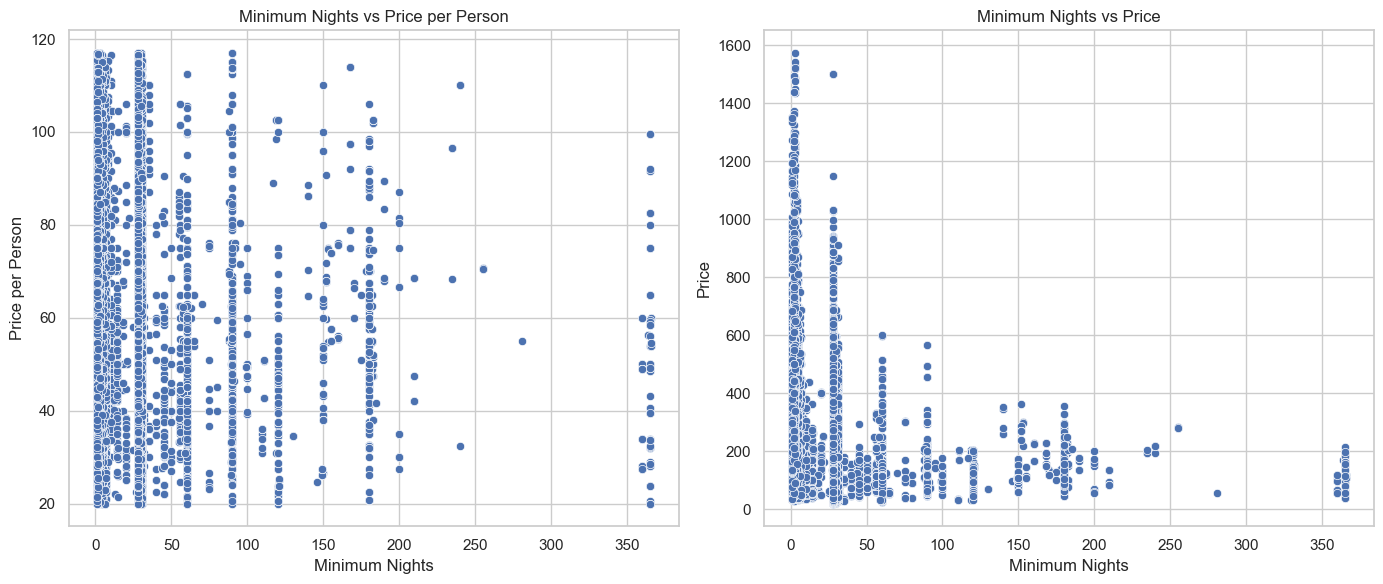

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatterplot for minimum_nights vs price_per_person
sns.scatterplot(data=final_df, x='minimum_nights', y='price_per_person', ax=axes[0])
axes[0].set_title('Minimum Nights vs Price per Person')
axes[0].set_xlabel('Minimum Nights')
axes[0].set_ylabel('Price per Person')

# Scatterplot for minimum_nights vs price
sns.scatterplot(data=final_df, x='minimum_nights', y='price', ax=axes[1])
axes[1].set_title('Minimum Nights vs Price')
axes[1].set_xlabel('Minimum Nights')
axes[1].set_ylabel('Price')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

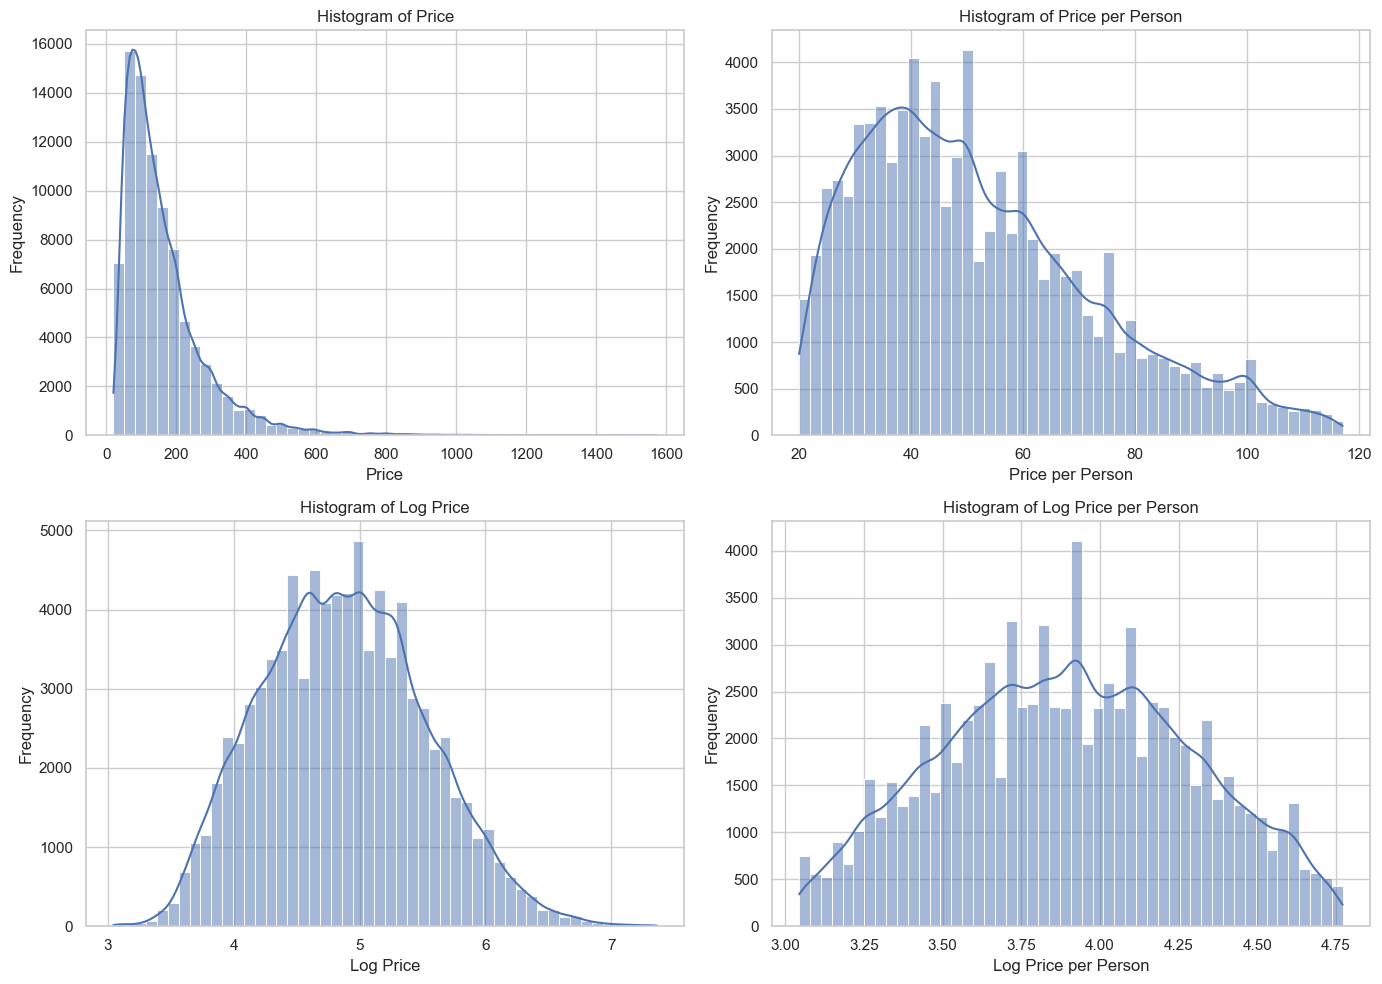

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")

# Create a figure with four subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram for price
sns.histplot(data=final_df, x='price', ax=axes[0, 0], bins=50, kde=True)
axes[0, 0].set_title('Histogram of Price')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')

# Histogram for price_per_person
sns.histplot(data=final_df, x='price_per_person', ax=axes[0, 1], bins=50, kde=True)
axes[0, 1].set_title('Histogram of Price per Person')
axes[0, 1].set_xlabel('Price per Person')
axes[0, 1].set_ylabel('Frequency')

# Histogram for log_price
sns.histplot(data=final_df, x='log_price', ax=axes[1, 0], bins=50, kde=True)
axes[1, 0].set_title('Histogram of Log Price')
axes[1, 0].set_xlabel('Log Price')
axes[1, 0].set_ylabel('Frequency')

# Histogram for log_price_per_person
sns.histplot(data=final_df, x='log_price_per_person', ax=axes[1, 1], bins=50, kde=True)
axes[1, 1].set_title('Histogram of Log Price per Person')
axes[1, 1].set_xlabel('Log Price per Person')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [23]:
# paste into your notebook
import numpy as np
import scipy.stats as stats

cols = ['price', 'price_per_person', 'log_price', 'log_price_per_person']
for c in cols:
    vals = final_df[c].dropna().values
    skew = stats.skew(vals)
    kurt = stats.kurtosis(vals)   # Fisher (0 for normal)
    shapiro_p = stats.shapiro(vals[:5000])[1] if len(vals)>3 else np.nan  # sample-limited
    print(f"{c}: skew={skew:.3f}, kurtosis={kurt:.3f}, shapiro_p≈{shapiro_p:.3g}")

price: skew=2.624, kurtosis=12.508, shapiro_p≈1.31e-64
price_per_person: skew=0.772, kurtosis=0.000, shapiro_p≈7.08e-38
log_price: skew=0.215, kurtosis=-0.286, shapiro_p≈4.9e-14
log_price_per_person: skew=0.017, kurtosis=-0.725, shapiro_p≈2.4e-19


### 8. Finalize & Save Modeling Dataset

In [24]:
import re

def check_sanitization(df, columns_to_check):
    """
    Checks if the specified columns in the DataFrame are suitably sanitized.
    Reports any remaining HTML tags, surrogates, or non-ASCII characters.
    """
    issues_found = False
    
    for col in columns_to_check:
        if col not in df.columns:
            print(f"Column '{col}' not found in DataFrame.")
            continue
        
        print(f"\nChecking column: '{col}'")
        
        # Check for HTML tags
        html_mask = df[col].astype(str).str.contains(r'<.*?>', regex=True)
        if html_mask.any():
            issues_found = True
            print(f"  - Found HTML tags in {html_mask.sum()} rows.")
        
        # Check for surrogates
        surrogate_mask = df[col].astype(str).str.contains(r'[\ud800-\udfff]', regex=True)
        if surrogate_mask.any():
            issues_found = True
            print(f"  - Found surrogate characters in {surrogate_mask.sum()} rows.")
        
        # Check for non-ASCII characters (optional, as per previous cleaning)
        non_ascii_mask = df[col].astype(str).str.contains(r'[^\x00-\x7F]', regex=True)
        if non_ascii_mask.any():
            issues_found = True
            print(f"  - Found non-ASCII characters in {non_ascii_mask.sum()} rows.")
        
        if not (html_mask.any() or surrogate_mask.any() or non_ascii_mask.any()):
            print("  - Column appears sanitized.")
    
    if not issues_found:
        print("\nAll specified columns are suitably sanitized.")
    else:
        print("\nIssues found in sanitization.")

# Usage: Check 'description' and 'amenities' columns
check_sanitization(final_df, ['description', 'amenities'])


Checking column: 'description'
  - Column appears sanitized.

Checking column: 'amenities'
  - Column appears sanitized.

All specified columns are suitably sanitized.


In [25]:
# Save to Parquet
output_path = os.path.join(OUTPUT_DATA_DIR, OUTPUT_FILENAME)
print(f"\nSaving to {output_path}...")
final_df.to_parquet(output_path, index=False)
print("Done.")


Saving to ../data/toronto/toronto_dataset_oct_20.parquet...
Done.


In [26]:
# Save a sample with all occurrences of 2 random listings
sample_ids = np.random.choice(final_df['id'].unique(), size=2, replace=False)
sample_df = final_df[final_df['id'].isin(sample_ids)]
sample_output_path = os.path.join(OUTPUT_DATA_DIR, f"{CITY}_sample_listings_oct_20.csv")
sample_df.to_csv(sample_output_path, index=False)
print(f"Sample listings saved to {sample_output_path}.")

Sample listings saved to ../data/toronto/toronto_sample_listings_oct_20.csv.
